# Creating Abnormal Packets With Anomalies

In [8]:
#importing necessary libraries
from scapy.all import *
import random
import time

# Create a function to generate an abnormal packet with specified anomalies
def generate_abnormal_packet():
    payload = Raw(load="Normal data") #Default payload
    # Generate random IP and MAC addresses
    src_ip = f"192.168.{random.randint(0, 255)}.{random.randint(0, 255)}"
    dst_ip = f"10.0.{random.randint(0, 255)}.{random.randint(0, 255)}"
    src_mac = RandMAC()
    dst_mac = RandMAC()

    # Generate random protocol
    protocols = ['ARP', 'ICMP', 'HTTPS', 'HTTP', 'UDP', 'TCP']
    protocol = random.choice(protocols)

    # Generate packet based on protocol
    if protocol == 'ARP':
        transport_layer = ARP(pdst="192.168.1.1", hwdst=RandMAC())
        anomaly_type = 'none'  # No anomalies for ARP packets
    else:
        transport_layer = TCP(sport=RandShort(), dport=80) if protocol == 'TCP' else \
                          UDP(sport=RandShort(), dport=53) if protocol == 'UDP' else \
                          ICMP(type=8, code=0) if protocol == 'ICMP' else \
                          IP()  # Placeholder for non-IP protocols
        anomaly_type = random.choice(['payload', 'length', 'none'])

    # Add anomaly based on anomaly_type
    if anomaly_type == 'payload':
        payload_data = b"Anomaly in payload"
        payload = Raw(load=payload_data)
        anomaly_explanation = "Anomaly introduced in payload content."
    elif anomaly_type == 'length':
        payload_data = b"Normal data" + b"A" * 100  # Increase payload size
        payload = Raw(load=payload_data)
        anomaly_explanation = "Anomaly introduced by increasing packet length."
    
    # Create packet with Ether/IP layers
    packet = Ether(src=src_mac, dst=dst_mac) / IP(src=src_ip, dst=dst_ip) / transport_layer / payload

    return packet

# Generate abnormal packets with anomalies and add timestamp delay
abnormal_packets = [] #create an empty list
for _ in range(325000):
    packet = generate_abnormal_packet()
    abnormal_packets.append(packet)

    # Add a timestamp delay (0.001 seconds) before generating the next packet
    time.sleep(0.001)

# Write the abnormal packets to a pcap file
wrpcap('packets_with_anomalies.pcap', abnormal_packets)

# Combining the normal and abnormal packets

In [9]:
from scapy.all import rdpcap, wrpcap

# Read packets from the first pcap file
packets_file1 = rdpcap('packets_with_anomalies.pcap')

# Read packets from the second pcap file
packets_file2 = rdpcap('Normal packets.pcap')

# Combine packets from both files
combined_packets = packets_file1 + packets_file2

# Write the combined packets to a new pcap file
wrpcap('combined_packets.pcap', combined_packets)


# Shuffling of the packets

In [2]:
import random
from scapy.all import *

# Read the combined packets from the pcap file
combined_packets = rdpcap('combined_packets.pcap')

# Convert the PacketList to a Python list
packet_list = list(combined_packets)

# Shuffle the packets
random.shuffle(packet_list)

# Create a new PacketList from the shuffled list
shuffled_packets = PacketList(packet_list)

# Write the shuffled packets to a new pcap file
wrpcap('shuffled_packets.pcap', shuffled_packets)

# Fetching all the features necessary for model building and saving to csv file

In [3]:
import pandas as pd
from scapy.all import *

# Read the shuffled packets from the pcap file
packets = rdpcap('shuffled_packets.pcap')

# Create lists to store the extracted data
timestamps = []
packet_lengths = []
info_data = []
source_protocols = []
destination_protocols = []
source_mac_addresses = []
destination_mac_addresses = []
protocols = []
tcp_flags = []

# Extract the desired fields from each packet
for packet in packets:
    # Extract the timestamp
    timestamps.append(packet.time)

    # Extract the packet length
    packet_lengths.append(len(packet))

    # Extract the info data (assuming it's present in the packet)
    info_data.append(packet.summary())

    # Extract source and destination protocols
    source_protocols.append(packet[0].name)
    destination_protocols.append(packet[1].name)

    # Extract source and destination MAC addresses (assuming it's an Ethernet packet)
    if packet.haslayer(Ether):
        source_mac_addresses.append(packet[Ether].src)
        destination_mac_addresses.append(packet[Ether].dst)
    else:
        source_mac_addresses.append(None)
        destination_mac_addresses.append(None)

    # Extract the protocol (e.g., TCP, UDP, ICMP)
    if packet.haslayer(IP):
        protocols.append(packet[IP].proto)
    else:
        protocols.append(None)

    # Extract TCP flags (assuming it's a TCP packet)
    if packet.haslayer(TCP):
        tcp_flags.append(packet[TCP].flags)
    else:
        tcp_flags.append(None)

# Create a DataFrame to organize the data
data = {
    'Timestamp': timestamps,
    'Length': packet_lengths,
    'Info': info_data,
    'Source Protocol': source_protocols,
    'Destination Protocol': destination_protocols,
    'Source MAC Address': source_mac_addresses,
    'Destination MAC Address': destination_mac_addresses,
    'Protocol': protocols,
    'TCP Flags': tcp_flags,
}

df = pd.DataFrame(data)

# Write the DataFrame to a CSV file
df.to_csv('packet_info1.csv', index=False)


# Data Cleaning Procedure

In [47]:
#reading the csv file
import pandas as pd
df=pd.read_csv('packet_info1.csv')
df.head(12)

,Timestamp,Length,Info,Source Protocol,Destination Protocol,Source MAC Address,Destination MAC Address,Protocol,TCP Flags
0,1691853484,72,Ether / IP / 127.0.0.1 > 127.0.0.1 ip / Raw,Ethernet,IP,21:d4:46:e4:78:0e,a8:09:ae:9d:59:65,4.0,NaN
1,1691854115,60,Ether / IP / ICMP 192.168.195.249 > 10.0.197.4...,Ethernet,IP,cf:86:64:23:0f:42,8c:7a:6c:96:88:60,1.0,NaN
2,1691916432,1292,Ether / IPv6 / UDP 2404:6800:4007:7::6:https >...,Ethernet,IPv6,1e:a9:2a:c0:e5:4d,7c:70:db:56:e9:56,NaN,NaN
3,1691851361,165,Ether / IP / 127.0.0.1 > 127.0.0.1 ip / Raw,Ethernet,IP,31:f0:8d:c4:72:3d,dd:99:cd:67:7a:da,4.0,NaN
4,1691850888,60,Ether / IP / ICMP 192.168.89.60 > 10.0.196.21 ...,Ethernet,IP,10:b9:4f:d9:97:d9,7f:9e:18:6d:45:76,1.0,NaN
5,1691918135,1424,Ether / IP / TCP 20.114.189.70:https > 192.168...,Ethernet,IP,1e:a9:2a:c0:e5:4d,7c:70:db:56:e9:56,6.0,PA
6,1691920247,1292,Ether / IPv6 / UDP 2405:200:1630:ff0c::d:https...,Ethernet,IPv6,1e:a9:2a:c0:e5:4d,7c:70:db:56:e9:56,NaN,NaN
7,1691919574,1292,Ether / IPv6 / UDP 2405:200:1630:ff0c::d:https...,Ethernet,IPv6,1e:a9:2a:c0:e5:4d,7c:70:db:56:e9:56,NaN,NaN
8,1691919265,572,Ether / IP / TCP 192.168.194.92:61185 > 103.89...,Ethernet,IP,7c:70:db:56:e9:56,1e:a9:2a:c0:e5:4d,6.0,PA
9,1691918065,54,Ether / IP / TCP 192.168.194.92:60940 > 103.89...,Ethernet,IP,7c:70:db:56:e9:56,1e:a9:2a:c0:e5:4d,6.0,A


In [46]:
df.columns

Index(['Timestamp', 'Length', 'Info', 'Source Protocol',
       'Destination Protocol', 'Source MAC Address', 'Destination MAC Address',
       'Protocol', 'TCP Flags'],
      dtype='object')

In [23]:
#encoding mac address columns
from sklearn.preprocessing import LabelEncoder

# Create a LabelEncoder instance
encoder = LabelEncoder()

# Encode the Source MAC Address and Destination MAC Address columns
df['Encoded_Source_MAC'] = encoder.fit_transform(df['Source MAC Address'])
df['Encoded_Destination_MAC'] = encoder.fit_transform(df['Destination MAC Address'])
 

In [39]:
df.head()

,Timestamp,Length,Info,Source Protocol,Destination Protocol,Source MAC Address,Destination MAC Address,Protocol,TCP Flags,Encoded_Source_MAC,Encoded_Destination_MAC,s_mac,d_mac,decoded_source_mac,decoded_destination_mac
0,1.691853e+09,72,Ether / IP / 127.0.0.1 > 127.0.0.1 ip / Raw,Ethernet,IP,"[0.12941176470588237, 0.8313725490196079, 0.27...","[0.6588235294117647, 0.03529411764705882, 0.68...",4.0,N/A,43383,213494,"[0.12941176470588237, 0.8313725490196079, 0.27...","[0.6588235294117647, 0.03529411764705882, 0.68...",21:D4:46:E4:78:0E,A8:09:AE:9D:59:65
1,1.691854e+09,60,Ether / IP / ICMP 192.168.195.249 > 10.0.197.4...,Ethernet,IP,"[0.8117647058823529, 0.5254901960784314, 0.392...","[0.5490196078431373, 0.47843137254901963, 0.42...",1.0,N/A,263413,178573,"[0.8117647058823529, 0.5254901960784314, 0.392...","[0.5490196078431373, 0.47843137254901963, 0.42...",CF:86:64:23:0F:42,8C:7A:6C:96:88:60
2,1.691916e+09,1292,Ether / IPv6 / UDP 2404:6800:4007:7::6:https >...,Ethernet,IPv6,"[0.11764705882352941, 0.6627450980392157, 0.16...","[0.48627450980392156, 0.4392156862745098, 0.85...",41.0,N/A,39220,158195,"[0.11764705882352941, 0.6627450980392157, 0.16...","[0.48627450980392156, 0.4392156862745098, 0.85...",1E:A9:2A:C0:E5:4D,7C:70:DB:56:E9:56
3,1.691851e+09,165,Ether / IP / 127.0.0.1 > 127.0.0.1 ip / Raw,Ethernet,IP,"[0.19215686274509805, 0.9411764705882353, 0.55...","[0.8666666666666667, 0.6, 0.803921568627451, 0...",4.0,N/A,63555,281163,"[0.19215686274509805, 0.9411764705882353, 0.55...","[0.8666666666666667, 0.6, 0.803921568627451, 0...",31:F0:8D:C4:72:3D,DD:99:CD:67:7A:DA
4,1.691851e+09,60,Ether / IP / ICMP 192.168.89.60 > 10.0.196.21 ...,Ethernet,IP,"[0.06274509803921569, 0.7254901960784313, 0.30...","[0.4980392156862745, 0.6196078431372549, 0.094...",1.0,N/A,21325,162236,"[0.06274509803921569, 0.7254901960784313, 0.30...","[0.4980392156862745, 0.6196078431372549, 0.094...",10:B9:4F:D9:97:D9,7F:9E:18:6D:45:76


In [41]:
df.drop(['s_mac','d_mac','decoded_source_mac','decoded_destination_mac'],inplace=True,axis=1)

In [47]:
df.head()

,Timestamp,Length,Info,Source Protocol,Destination Protocol,Source MAC Address,Destination MAC Address,Protocol,TCP Flags,Encoded_Source_MAC,Encoded_Destination_MAC
0,1.691853e+09,72,Ether / IP / 127.0.0.1 > 127.0.0.1 ip / Raw,Ethernet,IP,"[0.12941176470588237, 0.8313725490196079, 0.27...","[0.6588235294117647, 0.03529411764705882, 0.68...",4.0,NA,43383,213494
1,1.691854e+09,60,Ether / IP / ICMP 192.168.195.249 > 10.0.197.4...,Ethernet,IP,"[0.8117647058823529, 0.5254901960784314, 0.392...","[0.5490196078431373, 0.47843137254901963, 0.42...",1.0,NA,263413,178573
2,1.691916e+09,1292,Ether / IPv6 / UDP 2404:6800:4007:7::6:https >...,Ethernet,IPv6,"[0.11764705882352941, 0.6627450980392157, 0.16...","[0.48627450980392156, 0.4392156862745098, 0.85...",41.0,NA,39220,158195
3,1.691851e+09,165,Ether / IP / 127.0.0.1 > 127.0.0.1 ip / Raw,Ethernet,IP,"[0.19215686274509805, 0.9411764705882353, 0.55...","[0.8666666666666667, 0.6, 0.803921568627451, 0...",4.0,NA,63555,281163
4,1.691851e+09,60,Ether / IP / ICMP 192.168.89.60 > 10.0.196.21 ...,Ethernet,IP,"[0.06274509803921569, 0.7254901960784313, 0.30...","[0.4980392156862745, 0.6196078431372549, 0.094...",1.0,NA,21325,162236


In [7]:
# Assuming you want to fill missing "protocol" values with a specific value when "destination protocol" is IPv6
fill_value_ipv6 = 41  # You can replace this with the appropriate IPv6 protocol number

# Fill missing "protocol" values where "destination protocol" is IPv6
df.loc[df['Destination Protocol'] == 'IPv6', 'Protocol'] = fill_value_ipv6

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 728031 entries, 0 to 728030
Data columns (total 9 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   Timestamp                728031 non-null  float64
 1   Length                   728031 non-null  int64  
 2   Info                     728031 non-null  object 
 3   Source Protocol          728031 non-null  object 
 4   Destination Protocol     728031 non-null  object 
 5   Source MAC Address       728031 non-null  object 
 6   Destination MAC Address  728031 non-null  object 
 7   Protocol                 728031 non-null  float64
 8   TCP Flags                151753 non-null  object 
dtypes: float64(2), int64(1), object(6)
memory usage: 50.0+ MB


In [10]:
df['Protocol'].isna().sum()

657

In [12]:
df['Destination Protocol'].unique()

array(['IP', 'IPv6', 'ARP'], dtype=object)

In [13]:
df['Protocol'].fillna(2054, inplace=True)

In [16]:
filtered_df1 = df[(~df['Destination Protocol'].isnull()) & (df['TCP Flags'].isnull())]

In [17]:
df['TCP Flags'].fillna('N/A', inplace=True)

In [46]:
df['TCP Flags']=df['TCP Flags'].replace('N/A','NA')

In [11]:
filtered_df = df[(~df['Destination Protocol'].isnull()) & (df['Protocol'].isnull())]
filtered_df

,Timestamp,Length,Info,Source Protocol,Destination Protocol,Source MAC Address,Destination MAC Address,Protocol,TCP Flags
72,1.691920e+09,42,Ether / ARP is at 7c:70:db:56:e9:56 says 192.1...,Ethernet,ARP,7c:70:db:56:e9:56,1e:a9:2a:c0:e5:4d,NaN,NaN
915,1.691915e+09,42,Ether / ARP who has 192.168.194.92 says 192.16...,Ethernet,ARP,1e:a9:2a:c0:e5:4d,7c:70:db:56:e9:56,NaN,NaN
924,1.691919e+09,42,Ether / ARP who has 192.168.194.100 says 192.1...,Ethernet,ARP,1e:a9:2a:c0:e5:4d,ff:ff:ff:ff:ff:ff,NaN,NaN
1748,1.691915e+09,42,Ether / ARP who has 192.168.194.92 says 192.16...,Ethernet,ARP,1e:a9:2a:c0:e5:4d,7c:70:db:56:e9:56,NaN,NaN
1997,1.691918e+09,42,Ether / ARP is at 7c:70:db:56:e9:56 says 192.1...,Ethernet,ARP,7c:70:db:56:e9:56,1e:a9:2a:c0:e5:4d,NaN,NaN
...,...,...,...,...,...,...,...,...,...
723649,1.691921e+09,42,Ether / ARP is at 7c:70:db:56:e9:56 says 192.1...,Ethernet,ARP,7c:70:db:56:e9:56,1e:a9:2a:c0:e5:4d,NaN,NaN
724650,1.691918e+09,42,Ether / ARP who has 192.168.194.92 says 192.16...,Ethernet,ARP,1e:a9:2a:c0:e5:4d,7c:70:db:56:e9:56,NaN,NaN
725158,1.691915e+09,42,Ether / ARP is at 7c:70:db:56:e9:56 says 192.1...,Ethernet,ARP,7c:70:db:56:e9:56,1e:a9:2a:c0:e5:4d,NaN,NaN
725841,1.691917e+09,42,Ether / ARP who has 192.168.194.92 says 192.16...,Ethernet,ARP,1e:a9:2a:c0:e5:4d,7c:70:db:56:e9:56,NaN,NaN


In [51]:
import re

# Custom tokenizer function
def custom_tokenizer(text):
    # Check if the value is a string, if not, convert it to a string
    if not isinstance(text, str):
        text = str(text)
    
    # Split by spaces and symbols like "/"
    tokens = re.split(r'\s|/|>', text)
    # Remove empty strings and convert to lowercase
    tokens = [token.lower() for token in tokens if token]
    return tokens

# Apply the custom_tokenizer function to the "Info" column
df['info_tokens'] = df['Info'].apply(custom_tokenizer)

In [52]:
df['info_tokens'][0:3]

0           [ether, ip, 127.0.0.1, 127.0.0.1, ip, raw]
1    [ether, ip, icmp, 192.168.195.249, 10.0.197.43...
2    [ether, ipv6, udp, 2404:6800:4007:7::6:https, ...
Name: info_tokens, dtype: object

In [54]:
df['info_tokens'] = df['info_tokens'].apply(lambda x: ' '.join(x))

# Remove unnecessary characters
df['info_tokens'] = df['info_tokens'].apply(lambda x: re.sub(r"['\[\],]", "", x).replace('ip', '1').replace('ether', '2').replace('raw', '3'))

# Convert the cleaned "Info" column to numeric values
le = LabelEncoder()
df['info_tokens'] = le.fit_transform(df['info_tokens'])

In [55]:
df.head()

,Timestamp,Length,Info,Source Protocol,Destination Protocol,Source MAC Address,Destination MAC Address,Protocol,TCP Flags,Encoded_Source_MAC,Encoded_Destination_MAC,info_tokens
0,1.691853e+09,72,Ether / IP / 127.0.0.1 > 127.0.0.1 ip / Raw,Ethernet,IP,"[0.12941176470588237, 0.8313725490196079, 0.27...","[0.6588235294117647, 0.03529411764705882, 0.68...",4.0,NA,43383,213494,0
1,1.691854e+09,60,Ether / IP / ICMP 192.168.195.249 > 10.0.197.4...,Ethernet,IP,"[0.8117647058823529, 0.5254901960784314, 0.392...","[0.5490196078431373, 0.47843137254901963, 0.42...",1.0,NA,263413,178573,22773
2,1.691916e+09,1292,Ether / IPv6 / UDP 2404:6800:4007:7::6:https >...,Ethernet,IPv6,"[0.11764705882352941, 0.6627450980392157, 0.16...","[0.48627450980392156, 0.4392156862745098, 0.85...",41.0,NA,39220,158195,200211
3,1.691851e+09,165,Ether / IP / 127.0.0.1 > 127.0.0.1 ip / Raw,Ethernet,IP,"[0.19215686274509805, 0.9411764705882353, 0.55...","[0.8666666666666667, 0.6, 0.803921568627451, 0...",4.0,NA,63555,281163,0
4,1.691851e+09,60,Ether / IP / ICMP 192.168.89.60 > 10.0.196.21 ...,Ethernet,IP,"[0.06274509803921569, 0.7254901960784313, 0.30...","[0.4980392156862745, 0.6196078431372549, 0.094...",1.0,NA,21325,162236,51967


In [59]:
#one hot encoding nominal data
df=pd.get_dummies(df,columns=['Destination Protocol'],prefix=['dest_protocol'],dtype=int)

In [60]:
df.head()

,Timestamp,Length,Info,Source Protocol,Source MAC Address,Destination MAC Address,Protocol,TCP Flags,Encoded_Source_MAC,Encoded_Destination_MAC,info_tokens,dest_protocol_ARP,dest_protocol_IP,dest_protocol_IPv6
0,1.691853e+09,72,Ether / IP / 127.0.0.1 > 127.0.0.1 ip / Raw,Ethernet,"[0.12941176470588237, 0.8313725490196079, 0.27...","[0.6588235294117647, 0.03529411764705882, 0.68...",4.0,NA,43383,213494,0,0,1,0
1,1.691854e+09,60,Ether / IP / ICMP 192.168.195.249 > 10.0.197.4...,Ethernet,"[0.8117647058823529, 0.5254901960784314, 0.392...","[0.5490196078431373, 0.47843137254901963, 0.42...",1.0,NA,263413,178573,22773,0,1,0
2,1.691916e+09,1292,Ether / IPv6 / UDP 2404:6800:4007:7::6:https >...,Ethernet,"[0.11764705882352941, 0.6627450980392157, 0.16...","[0.48627450980392156, 0.4392156862745098, 0.85...",41.0,NA,39220,158195,200211,0,0,1
3,1.691851e+09,165,Ether / IP / 127.0.0.1 > 127.0.0.1 ip / Raw,Ethernet,"[0.19215686274509805, 0.9411764705882353, 0.55...","[0.8666666666666667, 0.6, 0.803921568627451, 0...",4.0,NA,63555,281163,0,0,1,0
4,1.691851e+09,60,Ether / IP / ICMP 192.168.89.60 > 10.0.196.21 ...,Ethernet,"[0.06274509803921569, 0.7254901960784313, 0.30...","[0.4980392156862745, 0.6196078431372549, 0.094...",1.0,NA,21325,162236,51967,0,1,0


In [62]:
df=pd.get_dummies(df,columns=['TCP Flags'],prefix=['TCP'],dtype=int)

In [63]:
df.head()

,Timestamp,Length,Info,Source Protocol,Source MAC Address,Destination MAC Address,Protocol,Encoded_Source_MAC,Encoded_Destination_MAC,info_tokens,...,dest_protocol_IPv6,TCP_A,TCP_FA,TCP_FPA,TCP_NA,TCP_PA,TCP_R,TCP_RA,TCP_S,TCP_SA
0,1.691853e+09,72,Ether / IP / 127.0.0.1 > 127.0.0.1 ip / Raw,Ethernet,"[0.12941176470588237, 0.8313725490196079, 0.27...","[0.6588235294117647, 0.03529411764705882, 0.68...",4.0,43383,213494,0,...,0,0,0,0,1,0,0,0,0,0
1,1.691854e+09,60,Ether / IP / ICMP 192.168.195.249 > 10.0.197.4...,Ethernet,"[0.8117647058823529, 0.5254901960784314, 0.392...","[0.5490196078431373, 0.47843137254901963, 0.42...",1.0,263413,178573,22773,...,0,0,0,0,1,0,0,0,0,0
2,1.691916e+09,1292,Ether / IPv6 / UDP 2404:6800:4007:7::6:https >...,Ethernet,"[0.11764705882352941, 0.6627450980392157, 0.16...","[0.48627450980392156, 0.4392156862745098, 0.85...",41.0,39220,158195,200211,...,1,0,0,0,1,0,0,0,0,0
3,1.691851e+09,165,Ether / IP / 127.0.0.1 > 127.0.0.1 ip / Raw,Ethernet,"[0.19215686274509805, 0.9411764705882353, 0.55...","[0.8666666666666667, 0.6, 0.803921568627451, 0...",4.0,63555,281163,0,...,0,0,0,0,1,0,0,0,0,0
4,1.691851e+09,60,Ether / IP / ICMP 192.168.89.60 > 10.0.196.21 ...,Ethernet,"[0.06274509803921569, 0.7254901960784313, 0.30...","[0.4980392156862745, 0.6196078431372549, 0.094...",1.0,21325,162236,51967,...,0,0,0,0,1,0,0,0,0,0


In [65]:
df.columns

Index(['Timestamp', 'Length', 'Info', 'Source Protocol', 'Source MAC Address',
       'Destination MAC Address', 'Protocol', 'Encoded_Source_MAC',
       'Encoded_Destination_MAC', 'info_tokens', 'dest_protocol_ARP',
       'dest_protocol_IP', 'dest_protocol_IPv6', 'TCP_A', 'TCP_FA', 'TCP_FPA',
       'TCP_NA', 'TCP_PA', 'TCP_R', 'TCP_RA', 'TCP_S', 'TCP_SA'],
      dtype='object')

In [67]:
df1=df[['Timestamp', 'Length','Protocol','Encoded_Source_MAC',
       'Encoded_Destination_MAC', 'info_tokens', 'dest_protocol_ARP',
       'dest_protocol_IP', 'dest_protocol_IPv6', 'TCP_A', 'TCP_FA', 'TCP_FPA',
       'TCP_NA', 'TCP_PA', 'TCP_R', 'TCP_RA', 'TCP_S', 'TCP_SA']]

In [69]:
df1.to_csv('Updated Packets.csv')

# Saving the cleaned file to an excel file

In [48]:
import pandas as pd
new=pd.read_excel('Updated Packets.xlsx',index_col=None)

KeyboardInterrupt: 

In [4]:
new.head()

,Unnamed: 0,Timestamp,Length,Protocol,Encoded_Source_MAC,Encoded_Destination_MAC,info_tokens,dest_protocol_ARP,dest_protocol_IP,dest_protocol_IPv6,TCP_A,TCP_FA,TCP_FPA,TCP_NA,TCP_PA,TCP_R,TCP_RA,TCP_S,TCP_SA
0,0,1.691853e+09,72,4,43383,213494,0,0,1,0,0,0,0,1,0,0,0,0,0
1,1,1.691854e+09,60,1,263413,178573,22773,0,1,0,0,0,0,1,0,0,0,0,0
2,2,1.691916e+09,1292,41,39220,158195,200211,0,0,1,0,0,0,1,0,0,0,0,0
3,3,1.691851e+09,165,4,63555,281163,0,0,1,0,0,0,0,1,0,0,0,0,0
4,4,1.691851e+09,60,1,21325,162236,51967,0,1,0,0,0,0,1,0,0,0,0,0


In [5]:
new.columns

Index(['Unnamed: 0', 'Timestamp', 'Length', 'Protocol', 'Encoded_Source_MAC',
       'Encoded_Destination_MAC', 'info_tokens', 'dest_protocol_ARP',
       'dest_protocol_IP', 'dest_protocol_IPv6', 'TCP_A', 'TCP_FA', 'TCP_FPA',
       'TCP_NA', 'TCP_PA', 'TCP_R', 'TCP_RA', 'TCP_S', 'TCP_SA'],
      dtype='object')

In [6]:
new.drop('Unnamed: 0',axis=1,inplace=True)

In [7]:
new.head(2)

,Timestamp,Length,Protocol,Encoded_Source_MAC,Encoded_Destination_MAC,info_tokens,dest_protocol_ARP,dest_protocol_IP,dest_protocol_IPv6,TCP_A,TCP_FA,TCP_FPA,TCP_NA,TCP_PA,TCP_R,TCP_RA,TCP_S,TCP_SA
0,1.691853e+09,72,4,43383,213494,0,0,1,0,0,0,0,1,0,0,0,0,0
1,1.691854e+09,60,1,263413,178573,22773,0,1,0,0,0,0,1,0,0,0,0,0


In [8]:
new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 728031 entries, 0 to 728030
Data columns (total 18 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   Timestamp                728031 non-null  float64
 1   Length                   728031 non-null  int64  
 2   Protocol                 728031 non-null  int64  
 3   Encoded_Source_MAC       728031 non-null  int64  
 4   Encoded_Destination_MAC  728031 non-null  int64  
 5   info_tokens              728031 non-null  int64  
 6   dest_protocol_ARP        728031 non-null  int64  
 7   dest_protocol_IP         728031 non-null  int64  
 8   dest_protocol_IPv6       728031 non-null  int64  
 9   TCP_A                    728031 non-null  int64  
 10  TCP_FA                   728031 non-null  int64  
 11  TCP_FPA                  728031 non-null  int64  
 12  TCP_NA                   728031 non-null  int64  
 13  TCP_PA                   728031 non-null  int64  
 14  TCP_

In [9]:
from sklearn.preprocessing import StandardScaler  #mean=0,standard deviation=1
scaler = StandardScaler()
scaled_data = scaler.fit_transform(new)
scaled_df = pd.DataFrame(scaled_data, columns=new.columns)

In [10]:
scaled_df

,Timestamp,Length,Protocol,Encoded_Source_MAC,Encoded_Destination_MAC,info_tokens,dest_protocol_ARP,dest_protocol_IP,dest_protocol_IPv6,TCP_A,TCP_FA,TCP_FPA,TCP_NA,TCP_PA,TCP_R,TCP_RA,TCP_S,TCP_SA
0,-1.074245,-0.659040,-0.306706,-1.022594,0.573784,-1.681125,-0.030054,0.906559,-0.904908,-0.276090,-0.074858,-0.012349,0.513160,-0.23007,-0.009876,-0.025551,-0.29021,-0.056577
1,-1.054443,-0.678210,-0.353868,1.136558,0.172023,-1.388994,-0.030054,0.906559,-0.904908,-0.276090,-0.074858,-0.012349,0.513160,-0.23007,-0.009876,-0.025551,-0.29021,-0.056577
2,0.900018,1.289942,0.274957,-1.063446,-0.062422,0.887173,-0.030054,-1.103072,1.105084,-0.276090,-0.074858,-0.012349,0.513160,-0.23007,-0.009876,-0.025551,-0.29021,-0.056577
3,-1.140819,-0.510470,-0.306706,-0.824647,1.352305,-1.681125,-0.030054,0.906559,-0.904908,-0.276090,-0.074858,-0.012349,0.513160,-0.23007,-0.009876,-0.025551,-0.29021,-0.056577
4,-1.155667,-0.678210,-0.353868,-1.239049,-0.015931,-1.014495,-0.030054,0.906559,-0.904908,-0.276090,-0.074858,-0.012349,0.513160,-0.23007,-0.009876,-0.025551,-0.29021,-0.056577
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
728026,0.792954,1.289942,0.274957,1.668412,-0.062422,0.885493,-0.030054,-1.103072,1.105084,-0.276090,-0.074858,-0.012349,0.513160,-0.23007,-0.009876,-0.025551,-0.29021,-0.056577
728027,0.896517,1.181310,0.274957,-1.063446,-0.062422,0.887160,-0.030054,-1.103072,1.105084,-0.276090,-0.074858,-0.012349,0.513160,-0.23007,-0.009876,-0.025551,-0.29021,-0.056577
728028,0.723524,-0.617504,0.274957,0.103270,1.772611,0.884685,-0.030054,-1.103072,1.105084,-0.276090,-0.074858,-0.012349,0.513160,-0.23007,-0.009876,-0.025551,-0.29021,-0.056577
728029,0.725421,-0.686198,-0.275265,0.103270,1.772611,-0.695463,-0.030054,0.906559,-0.904908,3.622013,-0.074858,-0.012349,-1.948711,-0.23007,-0.009876,-0.025551,-0.29021,-0.056577


In [11]:
from sklearn.decomposition import PCA   #principal component analysis
import pandas as pd

# Assuming 'scaled_df' is your DataFrame with scaled features
# Replace 'scaled_df' with the name of your scaled DataFrame

# Initialize the PCA with the number of components you want to retain

# Initialize PCA
pca = PCA(10)

# Fit PCA to your scaled data
principal_components = pca.fit_transform(scaled_df)

# Create a new DataFrame with the principal components
columns = [f'PC{i}' for i in range(1, 11)]
pca_df = pd.DataFrame(data=principal_components, columns=columns)

# 'pca_df' now contains the principal components after dimensionality reduction

In [12]:
pca_df

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10
0,-2.034358,0.511914,-1.048572,-0.165314,-0.184469,0.158216,-0.126524,0.134672,-0.046971,0.007154
1,-2.162965,0.428683,-0.811418,-0.193300,-0.838647,-0.300269,0.004826,-0.027324,0.026484,0.034447
2,2.506128,-0.120613,-0.513852,0.195787,0.548744,0.173062,-0.022201,0.029455,-0.027248,-0.030036
3,-2.026694,0.479780,-1.003969,-0.530811,-0.305053,0.007733,-0.215620,0.219463,-0.055251,0.009613
4,-1.791433,0.472145,-1.108005,0.082169,0.058630,0.266489,-0.059365,0.070791,-0.040777,0.002029
...,...,...,...,...,...,...,...,...,...,...
728026,2.159431,-0.160543,-0.215544,-0.061764,-0.368865,-0.473729,0.079081,-0.112028,0.055531,0.006247
728027,2.466789,-0.108422,-0.513325,0.177444,0.538421,0.181332,-0.021726,0.030596,-0.026617,-0.028954
728028,1.650831,0.034805,-0.304396,-1.107033,-0.194853,-0.169591,-0.196010,0.217029,-0.012504,0.007399
728029,-1.275393,-1.115305,2.819253,-2.725814,-1.532995,-0.351013,-0.065013,-0.072109,-0.109011,0.040626


# Model Building

In [13]:
from sklearn.ensemble import IsolationForest

In [14]:
model=IsolationForest(contamination=0.41,random_state=42,n_estimators=100)

In [15]:
model.fit(pca_df)

C:\Users\meghn\Desktop\anaconda\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


IsolationForest(contamination=0.41, random_state=42)

In [18]:
predicted_val=model.predict(pca_df)

In [19]:
predicted_val[0:5]

array([ 1,  1,  1, -1,  1])

In [20]:
anomaly_scores = model.decision_function(pca_df)

In [21]:
anomaly_scores

array([ 0.00537423,  0.02071781,  0.04570551, ...,  0.00010621,
       -0.09378127,  0.0693252 ])

## Visualoisation of results

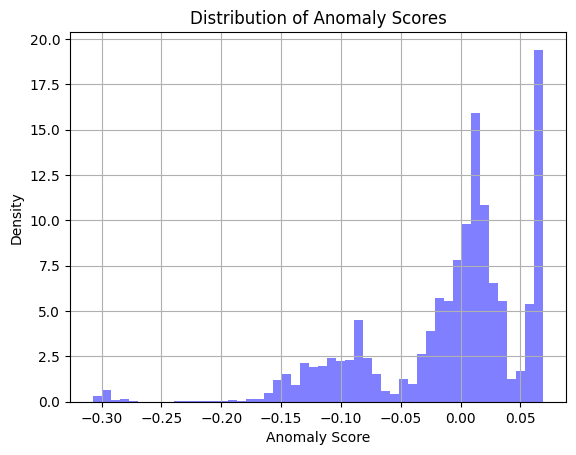

In [26]:
# Visualize the distribution of anomaly scores
import matplotlib.pyplot as plt

plt.hist(anomaly_scores, bins=50, density=True, alpha=0.5, color='blue')
plt.xlabel("Anomaly Score")
plt.ylabel("Density")
plt.title("Distribution of Anomaly Scores")
plt.grid(True)
plt.show()

In [40]:
#threshold setting 
threshold=0.001
normal_data=[] #empty lit
abnormal_data=[] #empty list
for i in anomaly_scores:
    if i<threshold:
        normal_data.append(i)
    else:
        abnormal_data.append(i)

In [41]:
#function for visualisation purpose
def visualize_distribution(normal_data, abnormal_data):
    # Create a histogram for normal data
    plt.hist(normal_data, bins=20, alpha=0.5, color='blue', label='Normal Data')

    # Create a histogram for abnormal data
    plt.hist(abnormal_data, bins=20, alpha=0.5, color='red', label='Abnormal Data')

    # Add labels and legend
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.title('Distribution of Normal and Abnormal Data')
    plt.legend()

    # Show the plot
    plt.show()

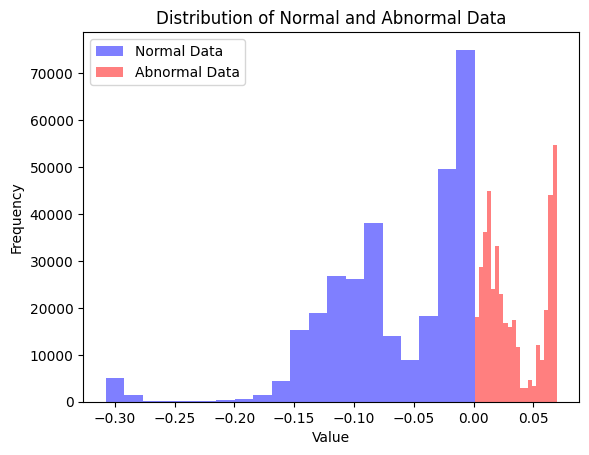

In [42]:
visualize_distribution(normal_data,abnormal_data) #function calling

## Model saving for later use

In [44]:
import joblib
model_filename = 'isolation_forest_model.pkl'
joblib.dump(model, model_filename)

['isolation_forest_model.pkl']